In [1]:
include(joinpath(pwd(), "MPC_functions.jl"))
using  Luna
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using LaTeXStrings
using Printf
using DSP
using HDF5
using PyPlot
pygui(true)
using Plots
using CSV
using DataFrames


In [145]:
PyPlot.rcdefaults() # reset to default
PyPlot.close("all")

# Set global plotting parameters for PyPlot.jl
PyPlot.rc("font", size=12)      #family="serif",
# PyPlot.rc("axes", titlesize=18, labelsize=16)
# PyPlot.rc("xtick", labelsize=12)
# PyPlot.rc("ytick", labelsize=12)
PyPlot.rc("lines", linewidth=1.5)
size_py = 0.393701*[20, 15]     # figure size
size_py_wide = 0.393701*[20, 8]# figure size in cm
res = 300                       # figure resolution (dpi)

300

In [5]:
# Set global plotting parameters for Plots.jl
default(
#       guidefont = font(16, "Times"),    # Axis label font
#       tickfont = font(14),              # Axis tick font
#       legendfontsize = 12,              # Legend font size
#       titlefont = font(18, "Arial"),    # Title font
        linewidth=2
  )
size_jl=(800,600)   # figure size in pixel
# closeall()


(800, 600)

In [152]:
out_path = joinpath(pwd(), "..", "..", "thesis")


"\\\\win.desy.de\\home\\muelderk\\My Documents\\MPC\\MPC_luna\\..\\..\\thesis"

## PAPER DATA

In [102]:
df = CSV.read(joinpath("input", "paper_caus_0.5_Xe.csv"), DataFrame)
z_caus = df[:,1]
caus = df[:,2]

df = CSV.read(joinpath("input", "paper_spec_0.5_Xe.csv"), DataFrame)
lamb = df[:,1]
spec = df[:,2]

println(caus[1])

0.0005463327370304115


## I) Read data from .h5 file

In [ ]:
run = "run_2025_07_22__11_37_33"
run_path = joinpath("output", run)
save_figs = true

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))
    
    # Read dataset
    global Eωr0 = read(file["Eωr0"])
    global Eωr_in = read(file["Eωr_in"])
    global Eωr_out = read(file["Eωr_out"])

    # Read beam waists
    global w_z = read(file["w_z"]) 
    global w_min = read(file["w_min"]) 
    global w_mirr = read(file["w_mirr"]) 
    
    global ω = read(file["ω"])
    global t = read(file["t"])
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


Regenerate Hankel transform matrix "q", simulation grid as well as additional coordinate axes rsym, f and λ

In [80]:
q = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
q_1D = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

L = params["L"]
λ0 = params["λ0"]
λlims = (params["λmin"], params["λmax"])
trange_request = params["trange_request"]

grid = Grid.RealGrid(L, λ0, λlims, trange_request)               # set up time & space grid for gradient approximation
f = ω./2π                      # sampled linear frequencies [Hz]
λ = PhysData.wlfreq.(ω)         # sampled wavelengths [m]
λ[1] = 1.0                        # avoid "Inf" value for DC frequency

┌ Info: Freq limits 0.26 - 0.33 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 3997.23, samples: 4096, δt = 500.35 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 2000.0 fs, actual time window: 2049.4 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 2048 / 4096, ωmax 3.14e+15 / 6.28e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78


1.0

## II) Analyze final output (last propagation step of last pass)

### a) Input vs. output spectrum and spectral phase

In [81]:
Eωr0_in = Eωr0[:,1,1]
Eωr0_out = Eωr0[:,end,end]

1025-element Vector{ComplexF64}:
  0.00031294864780666835 + 0.0im
 -0.00028302089418839584 + 0.00013387744459293784im
  0.00019879959630740378 - 0.00024240539787871197im
   -7.600674381746311e-5 + 0.00030483144454840875im
   -6.223173290802781e-5 - 0.0003088468876905136im
   0.0001895202400071006 + 0.0002530206314792359im
  -0.0002810587130355081 - 0.00014734267005809157im
   0.0003184128189710991 + 1.1670248540714033e-5im
 -0.00029330638937223136 + 0.00012777397045280096im
  0.00020963284056934155 - 0.00024333002196894242im
                         ⋮
   0.0011031685897515027 - 0.00023055018771951465im
  -0.0008062804399622505 + 0.0008065978813841995im
  0.00023679330251779454 - 0.0011273633555573597im
  0.00042009954464336844 + 0.0010828705505241155im
  -0.0009485627489774784 - 0.0006835069242953156im
   0.0011736381318263574 + 5.7132840666920945e-5im
  -0.0010193273370110334 + 0.0005927724220531837im
   0.0005340101168854811 - 0.0010540536152811293im
  0.00012520149165273032 + 0.0011

In [82]:
ϕω_in = unwrap_phase(ω, t, Eωr0_in)
ϕω_out = unwrap_phase(ω, t, Eωr0_out)

ϕω_in = blank_phase(ω, abs2.(Eωr0_in), ϕω_in; level=0.05)
ϕω_out = blank_phase(ω, abs2.(Eωr0_out), ϕω_out; level=0.05)

1025-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

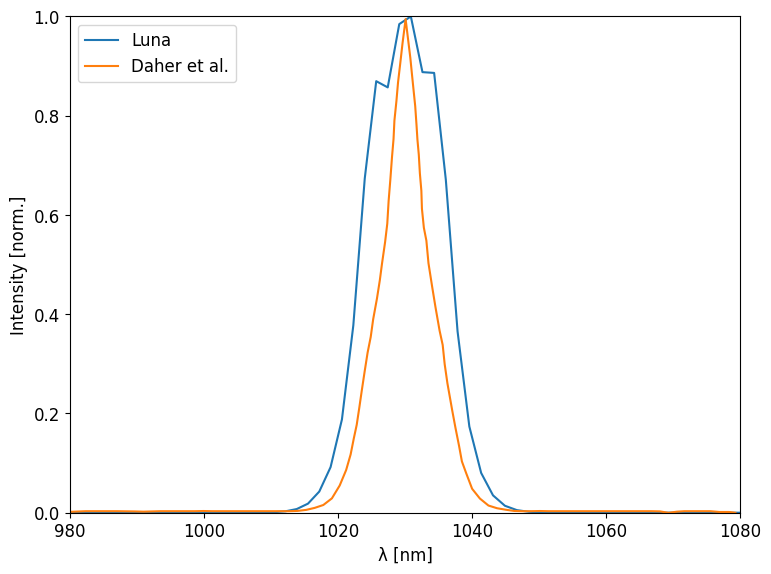

In [154]:
plt.figure(figsize=size_py)
# plt.title("Output spectrum comparison")
plt.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_out)), label="Luna")
plt.plot(lamb, spec, label="Daher et al.")
plt.xlim(950, 1100)
plt.ylim(0, 1)
plt.xlim(980, 1080)#λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("Intensity [norm.]")
plt.legend(loc="upper left")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(out_path, "spec_0.5_Xe_comp.png"), dpi=res) 
end
plt.gcf()

### b) Input vs. output pulse

In [84]:
Etr0_in = Maths.hilbert(FFTW.irfft(Eωr0_in, length(t), 1))
Etr0_out = Maths.hilbert(FFTW.irfft(Eωr0_out, length(t), 1))

ϕt_in = unwrap(angle.(Etr0_in))
ϕt_out = unwrap(angle.(Etr0_out))

ϕt_in = blank_phase(t, abs2.(Etr0_in), ϕt_in; level=0.05)
ϕt_out = blank_phase(t, abs2.(Etr0_out), ϕt_out; level=0.05)

2048-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

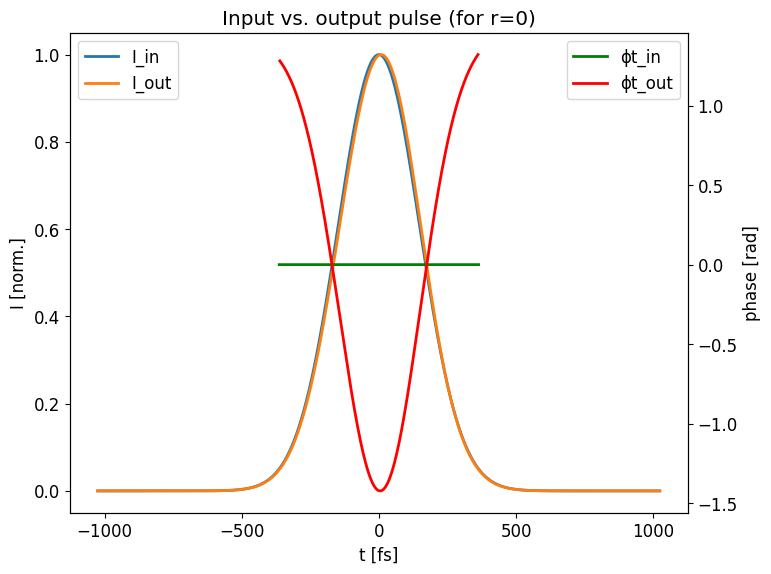

In [ ]:
fig, ax1 = plt.subplots(figsize=size_py)
ax1.set_title("LUNA: Input vs. output pulse (for r=0)")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_in)), label="I_in")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_out)), label="I_out")
ax2 = ax1.twinx()
ax2.plot(t.*1e15, detrend(ϕt_in), label="ϕt_in", color="green")
ax2.plot(t.*1e15, detrend(ϕt_out), label="ϕt_out", color="red")
# ax1.set_xlim(-200, 200)
ax1.set_xlabel("t [fs]")
ax1.set_ylabel("I [norm.]")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "pulse_in_vs_out.png"), dpi=res) 
end
plt.gcf()

### c) Spectral homogeinity across r

In [86]:
Irλ_out = transpose(Iwlfreq.(ω, abs2.(Eωr_out)))

256×1025 transpose(::Matrix{Float64}) with eltype Float64:
 0.0      1.93483e8       7.94184e8  …  4.06619e15  4.0379e15   4.0335e15
 0.0      2.1795e8        8.76866e8     1.09481e15  1.08702e15  1.08577e15
 0.0      2.95263e8       1.17269e9     3.18046e15  3.2026e15   3.21419e15
 0.0      1.51411e6       2.00593e7     3.69003e15  3.69666e15  3.7036e15
 0.0      3.59017e6       3.16667e7     2.03057e15  2.00244e15  1.99548e15
 0.0      1.10865e8       4.53134e8  …  2.21255e15  2.22188e15  2.22787e15
 0.0      3.31091e8       1.31342e9     1.85007e15  1.85756e15  1.86248e15
 0.0      4.14933e7       1.72174e8     3.09902e15  3.1022e15   3.10722e15
 0.0      3.53942e6       2.63097e7     4.2621e15   4.29465e15  4.31111e15
 0.0      1.12564e8       4.5513e8      2.32293e15  2.33607e15  2.34349e15
 ⋮                                   ⋱                          
 0.0      1.98303e5       7.94345e5     2.893e12    2.78743e12  2.75538e12
 0.0      6.39498e5       2.54045e6     2.47334e12  2

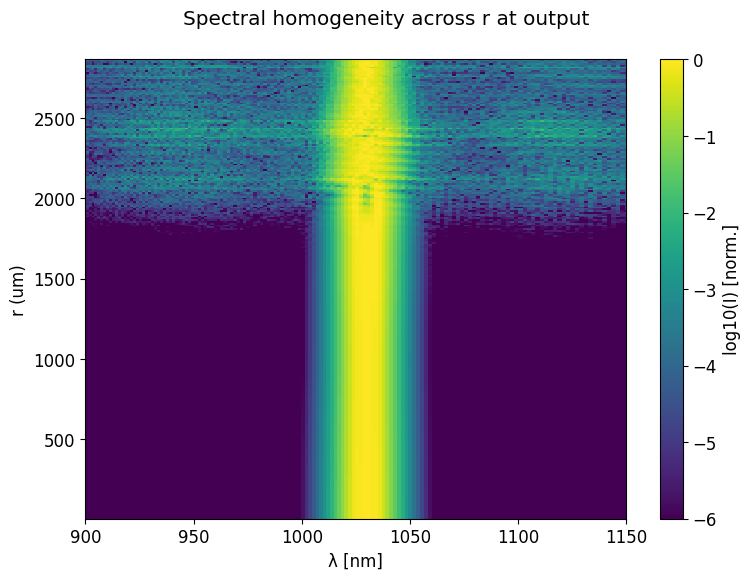

In [87]:
smallval = 1e-50

plt.figure(figsize=size_py)
plt.suptitle("Spectral homogeneity across r at output")
plt.pcolormesh(λ*1e9, r*1e6, Maths.log10_norm(Irλ_out .+smallval, 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log10(I) [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("r (um)") 
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_homogeneity.png"), dpi=res) 
end
plt.gcf()

### d) Spatiotemporal profile

In [88]:
Etr_out = Maths.hilbert(FFTW.irfft(Eωr_out, length(t), 1))

2048×256 Matrix{ComplexF64}:
  12007.5-1878.54im   1187.77-975.192im  …   -22.6505-43.2409im
 -1453.86+11954.2im   569.936+1439.95im       61.9165-5.77987im
 -10979.7-4659.37im   -1566.5+94.9483im      -20.2194+74.2765im
  7461.87-9130.07im   406.744-1543.35im      -76.6014-52.7535im
  6549.59+9591.74im   1363.53+882.145im       87.7333-66.2286im
 -10830.8+3483.68im  -1276.56+1041.13im  …    42.1462+120.006im
 -256.873-11059.2im  -611.084-1543.07im      -144.041+5.42984im
  10289.3+2773.77im   1650.95-124.501im       40.5985-154.819im
 -5280.28+8673.26im   -359.28+1591.21im       148.807+90.6002im
 -6479.13-7024.44im  -1378.28-782.505im      -137.893+124.828im
         ⋮                               ⋱           ⋮
 -7825.61+10969.3im  -183.237+1805.45im      -26.7948-37.8729im
  -8570.0-10327.7im  -1683.77-595.086im  …    39.5296-13.2543im
  12072.5-5589.56im   953.178-1458.9im      -0.544983+35.6814im
  2275.98+12943.5im   1155.01+1237.87im      -26.3579-11.9987im
 -12907.4-1114.66im 

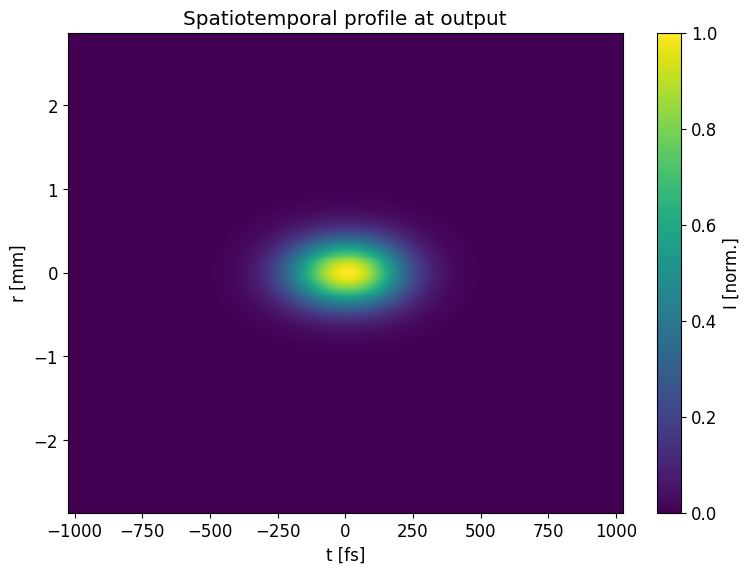

In [89]:
plt.figure(figsize=size_py) 
plt.title("Spatiotemporal profile at output")
plt.pcolormesh(t.*1e15, rsym.*1e3, Maths.normbymax(abs2.(Hankel.symmetric(Etr_out, q)')))
plt.colorbar(label="I [norm.]")
plt.xlabel("t [fs]")
plt.ylabel("r [mm]")
# plt.ylim(minimum(rsym*1e3), maximum(rsym*1e3))
# plt.xlim(minimum(t*1e15)/2, maximum(t*1e15)/2)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spatiotemporal_profile.png"), dpi=res) 
end
plt.gcf()

## III) Analyze overall pulse evolution across all passes

In [90]:
Nω = size(Eωr_in,1)
Nr = size(Eωr_in,2)
Nz = size(Eωr0,2)
Npass = size(Eωr0,3)

Nt = length(t)
Nrsym = length(rsym)

513

In [91]:
z_total = zeros(Nz, Npass)

for pass in 1:Npass 
    z_total[:,pass] = z .+ (pass-1)*z[end]
end

z_total = vcat(z_total...)

2010-element Vector{Float64}:
 0.0
 0.002755
 0.00551
 0.008265
 0.01102
 0.013775
 0.01653
 0.019285
 0.02204
 0.024795
 ⋮
 5.48796
 5.490715000000001
 5.49347
 5.496225000000001
 5.49898
 5.501735
 5.5044900000000005
 5.507245
 5.510000000000001

### a) Beams Caustic 

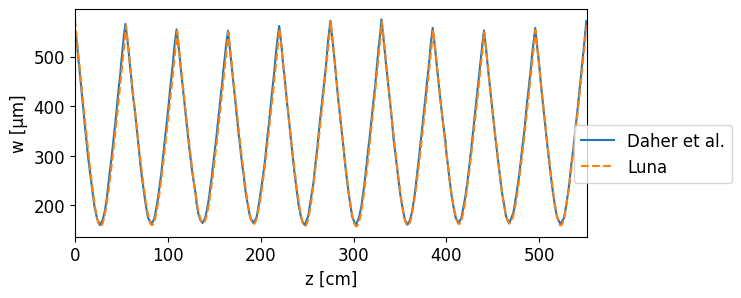

In [155]:
# PLOT CAUSTIC
plt.figure(figsize=size_py_wide) 
# plt.title("Caustic")
plt.plot(z_caus.*1e2, caus*1e6, label="Daher et al.")
plt.plot(z_total.*1e2, w_z.*1e6, label="Luna", linestyle="--")
plt.xlabel("z [cm]")
plt.ylabel("w [μm]")
plt.xlim(0,maximum(z_total.*1e2))
# plt.ylim(500, 600)
plt.legend(loc="lower right", bbox_to_anchor=(1.30, 0.2))
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(out_path, "caus_0.5_Xe_comp.png"), dpi=res) 
end
plt.gcf()

<!-- ### b) Minimum beam waist per pass -->

In [115]:
println(caus[1]*1e6)
println(w_z[1]*1e6)

546.3327370304115
574.3053496818428


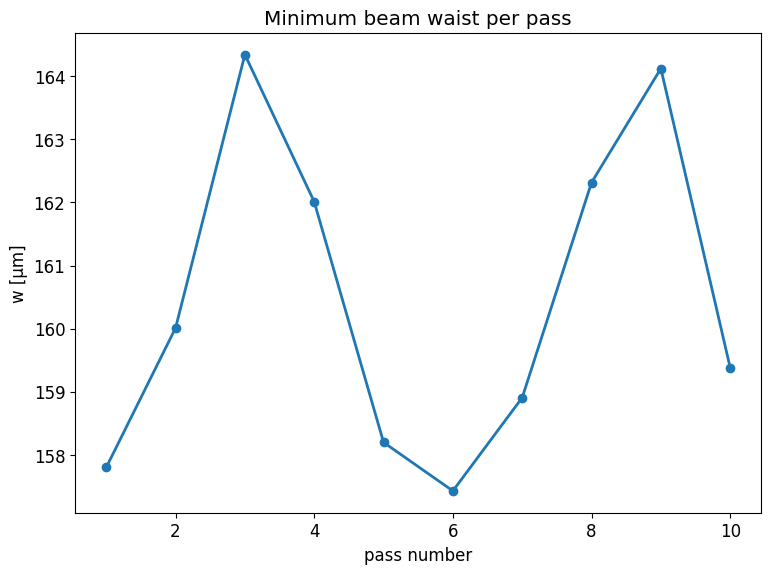

In [119]:
# PLOT minimum beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Minimum beam waist per pass")
plt.plot(1:Npass, w_min.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
# plt.ylim(95,125)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_minimum.png"), dpi=res) 
end
plt.gcf()

### c) Mirror beam waist per pass

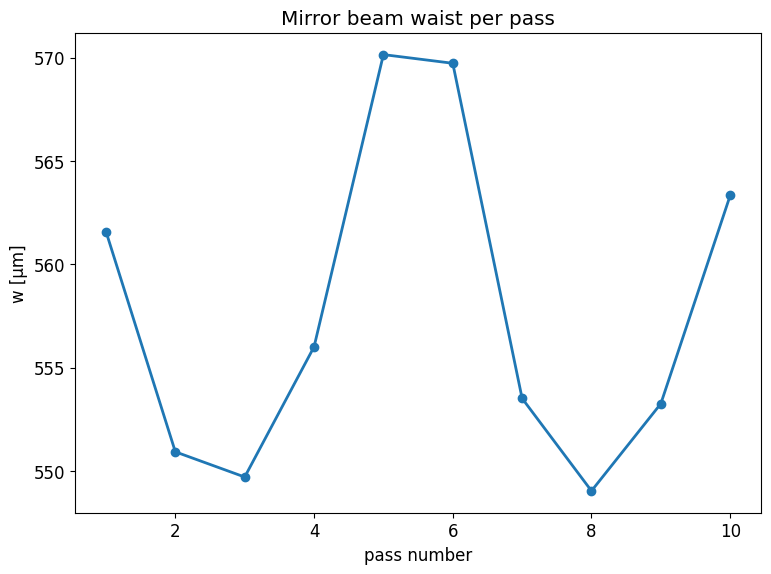

In [120]:
# PLOT mirror beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Mirror beam waist per pass")
plt.plot(1:Npass, w_mirr.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

### d) Spectral evolution (vs. λ)

In [121]:
Iωr0 = abs2.(Eωr0)    # convert to intensity
Iλr0 = Iwlfreq.(ω, Iωr0)

1025×201×10 Array{Float64, 3}:
[:, :, 1] =
 0.0         0.0         0.0         …  0.0         0.0         0.0
 1.40147e23  5.43983e15  1.80714e15     1.56452e8   5.19742e7   1.72661e7
 1.98595e23  6.17884e16  2.05265e16     6.56845e8   2.18208e8   7.249e7
 2.35208e22  2.87332e17  9.54533e16     1.59502e9   5.29874e8   1.76027e8
 1.0616e24   8.73266e17  2.90104e17     3.12966e9   1.03969e9   3.45391e8
 1.608e24    2.07498e18  6.8932e17   …  5.4874e9    1.82295e9   6.05594e8
 1.79395e24  4.20025e18  1.39535e18     8.96643e9   2.9787e9    9.89543e8
 8.42533e24  7.59471e18  2.52301e18     1.394e10    4.63095e9   1.53843e9
 1.87989e25  1.26252e19  4.19417e18     2.0859e10   6.92947e9   2.30201e9
 3.29854e24  1.96612e19  6.53158e18     3.02527e10  1.00501e10  3.33871e9
 ⋮                                   ⋱                          ⋮
 8.13447e29  4.24415e24  1.40993e24     1.30082e17  4.32141e16  1.4356e16
 8.1617e29   4.55698e24  1.51385e24     1.38607e17  4.60459e16  1.52967e16
 8.18919e2

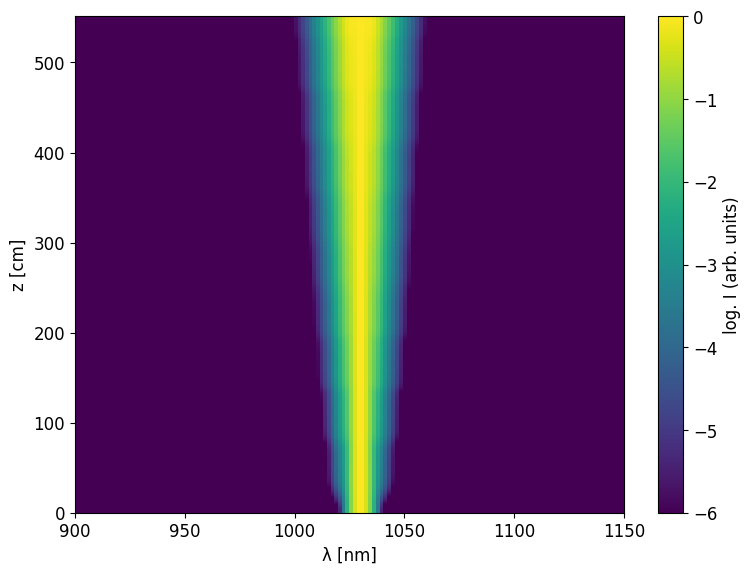

In [122]:
Iλr0_fused = hcat(eachslice(Iλr0, dims=3)...)

#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py)
# plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.log10_norm(transpose(Iλr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
# plt.ylim(0,75)
plt.xlabel("λ [nm]")
plt.ylabel("z [cm]")
# plt.xlim(700,1400)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl.png"), dpi=res) 
end
plt.gcf()


In [123]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.normbymax(Iλr0_fused[:, i]),
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(0, 1), 
#     xlabel=("λ [nm]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution.gif"), fps=24)

In [124]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.log10_norm(Iλr0_fused[:, i] .+smallval), 
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(-6, 0), 
#     xlabel=("λ [nm]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution_log.gif"), fps=24)

### E) Spectral evolution (vs. f)

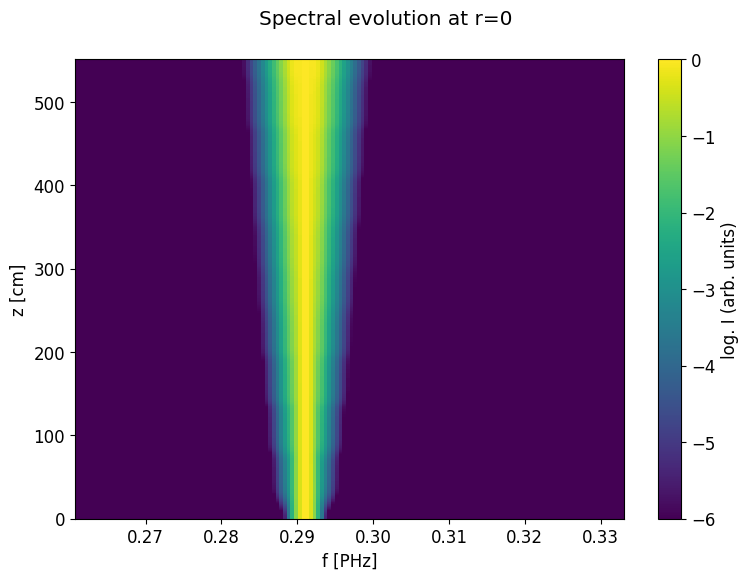

In [125]:
Iωr0_fused = hcat(eachslice(Iωr0, dims=3)...)

#+++++ PLOT 5: spectral evolution (against f) 
plt.figure(figsize=size_py)
plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(f*1e-15, z_total.*1e2, Maths.log10_norm(transpose(Iωr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(PhysData.wlfreq(λlims[2])/2pi*1e-15, PhysData.wlfreq(λlims[1])/2pi*1e-15)
plt.xlabel("f [PHz]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_f.png"), dpi=res) 
end
plt.gcf()

### f) Temporal evolution

In [126]:
Etr0 = zeros((size(Eωr0,1)-1)*2, size(Eωr0,2), size(Eωr0,3))
Itr0 = similar(Etr0)

for pass in 1:size(Eωr0,3)
    Etr0[:,:,pass] = FFTW.irfft(Eωr0[:,:,pass], length(t), 1)  # pulse for r=0
    Itr0[:,:,pass] = abs2.(Maths.hilbert(Etr0[:,:,pass]))           # temporal intensity for r=0
end

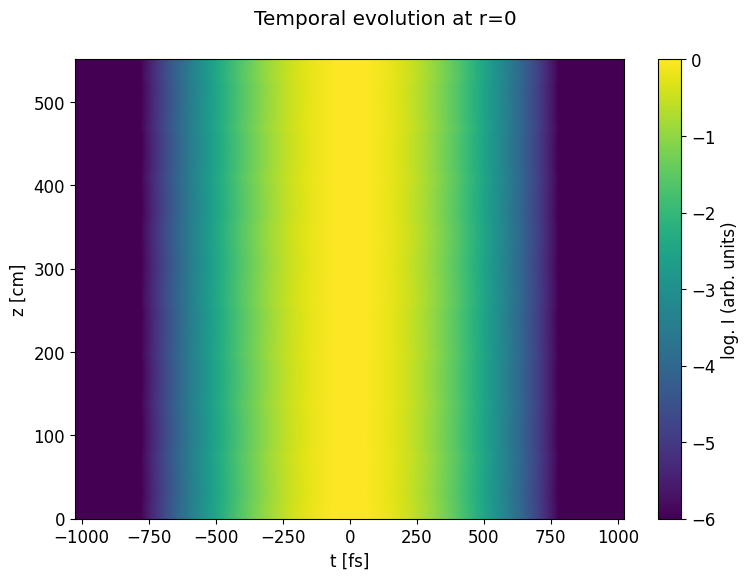

In [127]:
Itr0_fused = hcat(eachslice(Itr0, dims=3)...)

#+++++ PLOT 4: temporal evolution 
plt.figure(figsize=size_py)
plt.suptitle("Temporal evolution at r=0")
plt.pcolormesh(t.*1e15, z_total.*1e2, Maths.log10_norm(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(minimum(t)*1e15, maximum(t)*1e15)
plt.xlabel("t [fs]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "temporal_evolution.png"), dpi=res) 
end
plt.gcf()

In [128]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.normbymax(Itr0_fused[:, i]),
#     # size=size_jl,
#     ylim=(0, 1), 
#     xlabel=("t [fs]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution.gif"), fps=24)

In [129]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.log10_norm(Itr0_fused[:, i] .+smallval),
#     # size=size_jl,
#     ylim=(-6, 0), 
#     xlabel=("t [fs]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution_log.gif"), fps=24)

## B-Integral

In [130]:
I_peak = dropdims(maximum(Itr0, dims=1), dims=1)

201×10 Matrix{Float64}:
 7.80698e17  8.34839e17  8.79643e17  …  8.63231e17  8.82404e17  8.59456e17
 7.95225e17  8.50062e17  8.95886e17     8.79059e17  8.98833e17  8.75597e17
 8.10158e17  8.65684e17  9.12558e17     8.95301e17  9.15707e17  8.92181e17
 8.25508e17  8.81735e17  9.29693e17     9.11982e17  9.3304e17   9.09222e17
 8.41263e17  8.9821e17   9.47299e17     9.29105e17  9.50839e17  9.26742e17
 8.57488e17  9.15102e17  9.65349e17  …  9.46707e17  9.69152e17  9.44759e17
 8.74187e17  9.32491e17  9.83939e17     9.64801e17  9.8799e17   9.63306e17
 8.91369e17  9.50376e17  1.00307e18     9.83404e17  1.00736e18  9.82358e17
 9.09048e17  9.68761e17  1.02273e18     1.00249e18  1.02722e18  1.00189e18
 9.27245e17  9.87659e17  1.04296e18     1.02208e18  1.04764e18  1.02205e18
 ⋮                                   ⋱                          
 9.74874e17  1.0253e18   1.02939e18     1.027e18    9.98946e17  9.49004e17
 9.55603e17  1.00521e18  1.00951e18     1.00713e18  9.79764e17  9.30889e17
 9.36875e17

In [131]:
I_peak_fused = dropdims(hcat(I_peak...), dims=1)


2010-element Vector{Float64}:
 7.806977016730499e17
 7.952254991786868e17
 8.101580585818e17
 8.255077409667444e17
 8.412631241791854e17
 8.574877718023881e17
 8.741871566899822e17
 8.91369273050088e17
 9.090484416355131e17
 9.272453902068329e17
 ⋮
 9.490042680744822e17
 9.308894062061484e17
 9.132793800764392e17
 8.961424643103827e17
 8.794589067809549e17
 8.632234385365882e17
 8.474095625659581e17
 8.320062907640552e17
 8.170062869958774e17

In [132]:
size(z_total)

(2010,)

In [133]:
fac = 1e-4*PhysData.c*PhysData.ε_0/2 # to convert to intensities in W/cm^2

1.3272093647190362e-7

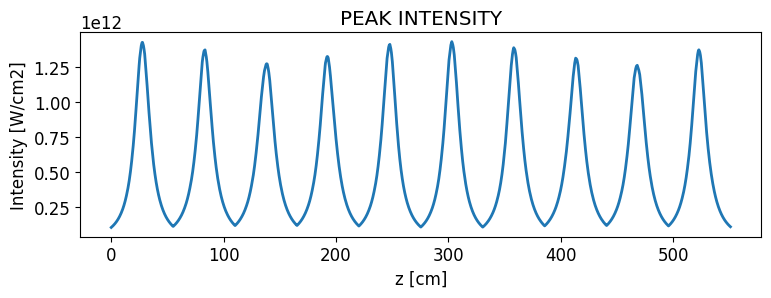

In [142]:
# PLOT PEAK INTENSITY
plt.figure(figsize=size_py_wide) 
plt.title("PEAK INTENSITY")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
plt.plot(z_total.*1e2, fac.*I_peak_fused)
plt.xlabel("z [cm]")
plt.ylabel("Intensity [W/cm2]")
# plt.ylim(0, 1.2e13)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

In [135]:
# integrate peak intensity over z for each pass
I_peak_int = zeros(size(I_peak,2))
for ii = 1:size(I_peak, 2)
    I_peak_int[ii] = integrate(z, I_peak[:, ii], SimpsonEven());
end

In [136]:
n2 = params["n2"]
B_int = 2pi/λ0*n2*I_peak_int
B_int .*= PhysData.c*PhysData.ε_0/2

10-element Vector{Float64}:
 0.5924650650301564
 0.583418261884904
 0.5789034041371066
 0.5805178876398205
 0.5865621692344485
 0.5922838087647637
 0.5838742636307813
 0.5756043319181325
 0.5745685476578721
 0.5782739267997661

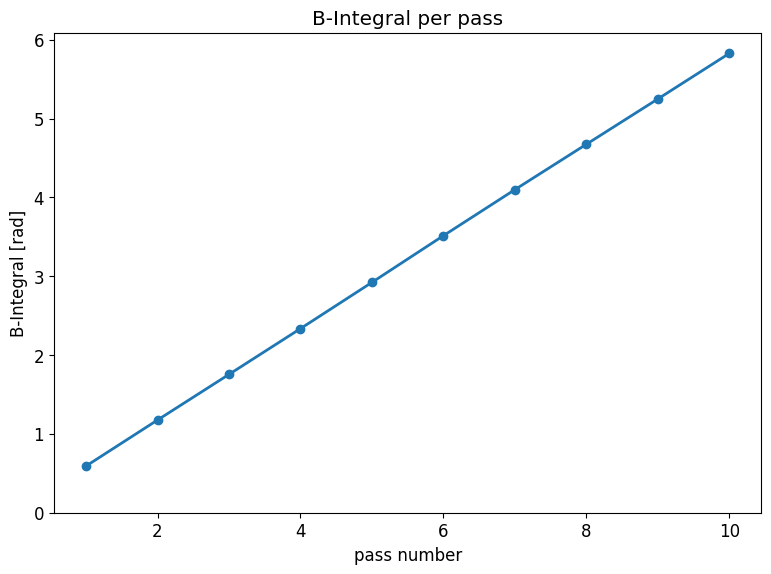

In [137]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, cumsum(B_int), marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

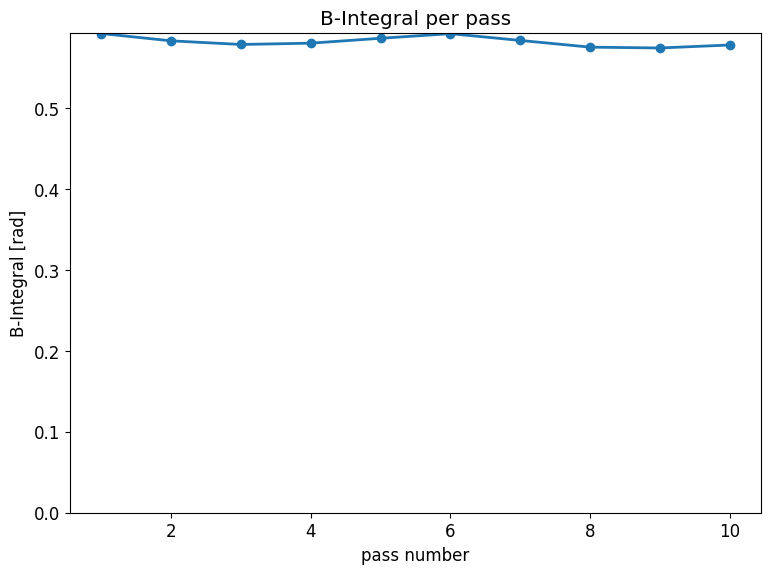

In [138]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, B_int, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

In [139]:
# Expected accumulated B-Integral based on eq.8 in Viotti et al. 2022
E_pulse = params["E_pulse"]
τ = params["τ"]
k = params["k"]
Nrt = params["Npass"]/2

P_peak = 0.94*E_pulse/τ
B_pass = 4*pi^2*n2*P_peak/λ0^2*(k/Nrt)
B_total = Nrt*B_pass

println("B_pass = ", B_pass)
println("B_total = ", B_total)

B_pass = 0.400396354357418
B_total = 2.00198177178709
